<a href="https://colab.research.google.com/github/TaewonHwang02/Akcse_project2024/blob/Model-Insertion/AKCSE_Summer_Project_Model_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#ED Trigger Detection Model
The objective of this training is to obtain the most accurate ML model capable of detecting ED (Specific or not) triggers from titles and transcripts of Youtube Videos.

The experiment consists of manipulating vrious preprocessing methods, finetuning parameters and of exploring different types of models, which will result in the most accurate model for use.

The models that we selected are Naive Bayes and Logistic Regression (for now).

The dataset was scraped from various Youtube videos, the resulting text transformed to a csv file with columns for title, transcript and "trigger level". This trigger level is a binary classifier that determines if a text is capable of triggering the ED in question (i.e., 0 for "no trigger" and 1 for "trigger").




In [20]:
import pandas as pd
import numpy as np
import os
import nltk
import csv
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
import pickle
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

# Transforming Webscraping Output to Desired Format

---


Although rather irrelevant to the actual code that trains the model, we will be applying our model in a Chrome extension that scrapes YouTube video titles and transcript.

This information provides us with the type of data we will be dealing with as input to the created model, thus allowing us to train our binary classifier more relevant to its actual use.

#Dataset

---


We will be training our model with 200 lines of titles and transcript, obtained from webscraping on YouTube.
All lines have been extracted from our webscraping code, representing its actual use inside of the Chrome extension.

In [3]:
# Read the content of "Triggers.txt"
with open("Triggers.txt", "r") as trigger_file:
    trigger_content = trigger_file.readlines()

# Read the content of "Normal.txt"
with open("Normal.txt", "r") as notrigger_file:
    notrigger_content = notrigger_file.readlines()

# Create DataFrames for trigger and non-trigger data
trigger_df = pd.DataFrame({'content': trigger_content, 'trigger level': 1})
notrigger_df = pd.DataFrame({'content': notrigger_content, 'trigger level': 0})

# Concatenate the DataFrames
df = pd.concat([trigger_df, notrigger_df], ignore_index=True)

# Save the DataFrame to a CSV file
df.to_csv('all_content.csv', index=False)

print("CSV file 'all_content.csv' created successfully!")

print(df.head())


CSV file 'all_content.csv' created successfully!
                                             content  trigger level
0                  WIEIAD Obese *Unhealthy* Part 4\n              1
1  [Music] what I eat in a day what I eat in a da...              1
2  WHAT I EAT IN A DAY AS A FAT PERSON - CALORIE ...              1
3  [Music] what e a fat [\xa0__\xa0] who very con...              1
4             TikToks That Will Make You Jealous 2\n              1


#Preprocessing Functions

Lemmatization


In [4]:
def lemmatize(content):
  # Initialize lemmatizer
  lemmatizer = WordNetLemmatizer()
  # Tokenize text (useful for preprocessing)
  con = content.split()
  #lemmatize text
  con_lemma = [lemmatizer.lemmatize(token) for token in con]
  con_lemma = ' '.join(con)
  return con_lemma

Word stemming

In [5]:
def wordStem(content):
  # Initialize Stemmer
  stemmer = PorterStemmer()
  # Tokenize text (useful for preprocessing)
  con = content.split()
  # Use the Stemmer
  con_stem = [stemmer.stem(token) for token in con]
  con_stem = ' '.join(con)
  return con_stem

Stopword Removal

In [7]:
def removeStopWord(content):
  # get english stopwords
  stop_words = set(stopwords.words('english'))
  # Tokenize text (useful for preprocessing)
  con = content.split()
  # Remove stopwords
  con_stop = [token for token in con if token.lower() not in stop_words]

  con_stop = ' '.join(con)
  return con_stop

# Training the Model

---



For all models, we will manipulate the above preprocessing methods,and finetune the parameters to get the most accurate model for our application.

## Preparing the Dataset

### Preprocessing

In [8]:
# No preprocessing
x = df['content']
y = df['trigger level']

# lemmatization
df['lemma'] = df['content'].apply(lemmatize)
x_lemma = df['lemma']

# Word Stemming
df['word stem'] = df['content'].apply(wordStem)
x_stem = df['word stem']

# Stop Word Removal
df['stop word'] = df['content'].apply(removeStopWord)
x_stopword = df['stop word']

In [9]:
print(df.head())

                                             content  trigger level  \
0                  WIEIAD Obese *Unhealthy* Part 4\n              1   
1  [Music] what I eat in a day what I eat in a da...              1   
2  WHAT I EAT IN A DAY AS A FAT PERSON - CALORIE ...              1   
3  [Music] what e a fat [\xa0__\xa0] who very con...              1   
4             TikToks That Will Make You Jealous 2\n              1   

                                               lemma  \
0                    WIEIAD Obese *Unhealthy* Part 4   
1  [Music] what I eat in a day what I eat in a da...   
2  WHAT I EAT IN A DAY AS A FAT PERSON - CALORIE ...   
3  [Music] what e a fat [\xa0__\xa0] who very con...   
4               TikToks That Will Make You Jealous 2   

                                           word stem  \
0                    WIEIAD Obese *Unhealthy* Part 4   
1  [Music] what I eat in a day what I eat in a da...   
2  WHAT I EAT IN A DAY AS A FAT PERSON - CALORIE ...   
3  [Music] w

Split dataset into training and testing sets

In [21]:
vect = TfidfVectorizer()

# No preprocessing
x_train , x_test , y_train, y_test = train_test_split(x, y, test_size=0.20)

x_train=vect.fit_transform(x_train)
x_test=vect.transform(x_test)

# Lemmatization
x_lemma_train , x_lemma_test , y_train, y_test = train_test_split(x_lemma, y, test_size=0.20)

x_lemma_train=vect.fit_transform(x_lemma_train)
x_lemma_test=vect.transform(x_lemma_test)

# Word Stemming
x_stem_train , x_stem_test , y_train, y_test = train_test_split(x_stem, y, test_size=0.20)

x_stem_train=vect.fit_transform(x_stem_train)
x_stem_test=vect.transform(x_stem_test)

# Stop Word Removal
x_stopword_train , x_stopword_test , y_train, y_test = train_test_split(x_stopword, y, test_size=0.20)

x_stopword_train=vect.fit_transform(x_stopword_train)
x_stopword_test=vect.transform(x_stopword_test)



##Naive Bayes

In [22]:
# No Preprocessing
# Instance of NB
nb_model = GaussianNB()

# Train the model
nb_model.fit(x_train.toarray(), y_train)
# Make predictions
nb_predictions = nb_model.predict(x_test.toarray())
# Evaluate the model
nb_accuracy = accuracy_score(y_test, nb_predictions)
nb_report = classification_report(y_test, nb_predictions)
nb_confusion = confusion_matrix(y_test, nb_predictions)

print("Naive Bayes No Preprocessing Accuracy:", nb_accuracy)
print("Naive Bayes No Preprocessing Report:", nb_report)


# Lemmatization
# Instance of NB
nb_lemma_model = GaussianNB()

# Train the model
nb_lemma_model.fit(x_lemma_train.toarray(), y_train)
# Make predictions
nb_lemma_predictions = nb_lemma_model.predict(x_lemma_test.toarray())
# Evaluate the model
nb_lemma_accuracy = accuracy_score(y_test, nb_lemma_predictions)

print("Naive Bayes Lemmatization Accuracy:", nb_lemma_accuracy)


# Word Stemming
# Instance of NB
nb_stem_model = GaussianNB()

# Train the model
nb_stem_model.fit(x_stem_train.toarray(), y_train)
# Make predictions
nb_stem_predictions = nb_stem_model.predict(x_stem_test.toarray())
# Evaluate the model
nb_stem_accuracy = accuracy_score(y_test, nb_stem_predictions)

print("Naive Bayes Word Stem Accuracy:", nb_stem_accuracy)


# Stop Word Removal
# Instance of NB
nb_stopword_model = GaussianNB()

# Train the model
nb_stopword_model.fit(x_stopword_train.toarray(), y_train)
# Make predictions
nb_stopword_predictions = nb_stopword_model.predict(x_stopword_test.toarray())
# Evaluate the model
nb_stopword_accuracy = accuracy_score(y_test, nb_stopword_predictions)

print("Naive Bayes Stop Word Removal Accuracy:", nb_stopword_accuracy)

Naive Bayes No Preprocessing Accuracy: 0.5
Naive Bayes No Preprocessing Report:               precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.56      0.83      0.67         6

    accuracy                           0.50        10
   macro avg       0.28      0.42      0.33        10
weighted avg       0.33      0.50      0.40        10

Naive Bayes Lemmatization Accuracy: 0.3
Naive Bayes Word Stem Accuracy: 0.6
Naive Bayes Stop Word Removal Accuracy: 1.0


### Finetuning
For a Gaussian Naive Bayes model, we will be using a grid search to explore the effects of smoothing variables on the overall performance.

In [23]:
# No preprocessing
# Define the hyperparameters to tune
param_grid = {'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]}

# Use GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(nb_model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(x_train.toarray(), y_train)

# Get the best model from grid search
finetune_best = grid_search.best_estimator_

# Make predictions using the best model
predictions = finetune_best.predict(x_test.toarray())

# Evaluate the model
finetune_accuracy = accuracy_score(y_test, predictions)
finetune_report = classification_report(y_test, predictions)

# Display results
print("Gaussian Naive Bayes Model Accuracy:", finetune_accuracy)
print("\nClassification Report:\n", finetune_report)


# Lemmatization
grid_search = GridSearchCV(nb_lemma_model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(x_lemma_train.toarray(), y_train)

finetune_lemma_best = grid_search.best_estimator_
predictions_lemma = finetune_lemma_best.predict(x_lemma_test.toarray())

# Evaluate the model
finetune_lemma_accuracy = accuracy_score(y_test, predictions_lemma)
finetune_lemma_report = classification_report(y_test, predictions_lemma)

# Display results
print("Lemma Accuracy:", finetune_lemma_accuracy)
print("Lemma Classification Report:", finetune_lemma_report)



# Word Stemming
grid_search = GridSearchCV(nb_stem_model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(x_stem_train.toarray(), y_train)

finetune_stem_best = grid_search.best_estimator_
predictions_stem = finetune_stem_best.predict(x_stem_test.toarray())

# Evaluate the model
finetune_stem_accuracy = accuracy_score(y_test, predictions_stem)
finetune_stem_report = classification_report(y_test, predictions_stem)

# Display results
print("Word Stem Accuracy:", finetune_stem_accuracy)
print("Word Stem Classification Report:", finetune_stem_report)



# Stop Word Removal
grid_search = GridSearchCV(nb_stopword_model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(x_stopword_train.toarray(), y_train)

finetune_stopword_best = grid_search.best_estimator_
predictions_stopword = finetune_stopword_best.predict(x_stopword_test.toarray())

# Evaluate the model
finetune_stopword_accuracy = accuracy_score(y_test, predictions_stopword)
finetune_stopword_report = classification_report(y_test, predictions_stopword)

# Display results
print("Stop Word Accuracy:", finetune_stopword_accuracy)
print("Stop Word Classification Report:", finetune_stopword_report)


Gaussian Naive Bayes Model Accuracy: 0.5

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.56      0.83      0.67         6

    accuracy                           0.50        10
   macro avg       0.28      0.42      0.33        10
weighted avg       0.33      0.50      0.40        10

Lemma Accuracy: 0.3
Lemma Classification Report:               precision    recall  f1-score   support

           0       0.20      0.25      0.22         4
           1       0.40      0.33      0.36         6

    accuracy                           0.30        10
   macro avg       0.30      0.29      0.29        10
weighted avg       0.32      0.30      0.31        10

Word Stem Accuracy: 0.6
Word Stem Classification Report:               precision    recall  f1-score   support

           0       0.50      0.75      0.60         4
           1       0.75      0.50      0.60         6

    accura

### Visualization

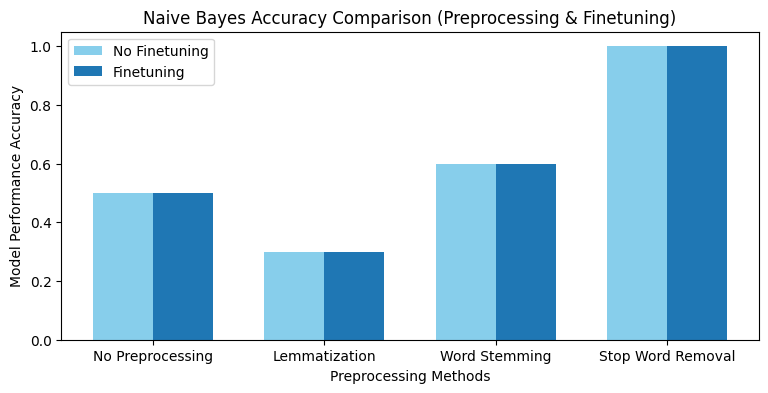

In [24]:
Categories = ['No Preprocessing', 'Lemmatization', 'Word Stemming', 'Stop Word Removal']
no_finetune = [nb_accuracy, nb_lemma_accuracy, nb_stem_accuracy, nb_stopword_accuracy]
finetuning = [finetune_accuracy, finetune_lemma_accuracy, finetune_stem_accuracy, finetune_stopword_accuracy]

bar_width = 0.35
index = np.arange(len(Categories))

plt.figure(figsize=(9, 4))
plt.bar(index, no_finetune, bar_width, label='No Finetuning', color='skyblue')
plt.bar(index + bar_width, finetuning, bar_width, label='Finetuning')

plt.xlabel('Preprocessing Methods')
plt.ylabel('Model Performance Accuracy')
plt.title('Naive Bayes Accuracy Comparison (Preprocessing & Finetuning)')
plt.xticks(index + bar_width / 2, Categories)
plt.legend()
plt.show()

##Logistic Regression

In [26]:
# No Preprocessing
# Create a Logistic Regression model
lr_model = LogisticRegression()

# Train the model
lr_model.fit(x_train, y_train)
# Make predictions
lr_predictions = lr_model.predict(x_test)
# Evaluate the model
lr_accuracy = accuracy_score(y_test, lr_predictions)

print("Logistic Regression Accuracy:", lr_accuracy)

# Lemmatization
# Create a Logistic Regression model
lr_lemma_model = LogisticRegression()

# Train the model
lr_lemma_model.fit(x_lemma_train, y_train)
# Make predictions
lr_lemma_predictions = lr_lemma_model.predict(x_lemma_test)
# Evaluate the model
lr_lemma_accuracy = accuracy_score(y_test, lr_lemma_predictions)

print("Logistic Regression Lemmatization Accuracy:", lr_lemma_accuracy)

# Word Stemming
# Create a Logistic Regression model
lr_stem_model = LogisticRegression()

# Train the model
lr_stem_model.fit(x_stem_train, y_train)
# Make predictions
lr_stem_predictions = lr_stem_model.predict(x_stem_test)
# Evaluate the model
lr_stem_accuracy = accuracy_score(y_test, lr_stem_predictions)

print("Logistic Regression Word Stemming Accuracy:", lr_stem_accuracy)

# Stop Word Removal
# Create a Logistic Regression model
lr_stopword_model = LogisticRegression()

# Train the model
lr_stopword_model.fit(x_stopword_train, y_train)
# Make predictions
lr_stopword_predictions = lr_stopword_model.predict(x_stopword_test)
# Evaluate the model
lr_stopword_accuracy = accuracy_score(y_test, lr_stopword_predictions)

print("Logistic Regression Stop Word Accuracy:", lr_stopword_accuracy)

Logistic Regression Accuracy: 0.4
Logistic Regression Lemmatization Accuracy: 0.6
Logistic Regression Word Stemming Accuracy: 0.7
Logistic Regression Stop Word Accuracy: 0.7


### Finetuning

In [27]:
# Define the hyperparameters and their respective ranges to tune
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'max_iter': [100, 200, 500]
}

# No preprocessing
# Initialize GridSearchCV
grid_search = GridSearchCV(lr_model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
# Fit the model with the best hyperparameters
grid_search.fit(x_train, y_train)
# Get the best model
best_lr_model = grid_search.best_estimator_

# Make predictions using the best model
lr_predictions = best_lr_model.predict(x_test)

# Evaluate the model
best_lr_accuracy = accuracy_score(y_test, lr_predictions)
lr_report = classification_report(y_test, lr_predictions, zero_division=0)

# Display results
print("Raw Logistic Regression Model Accuracy:", best_lr_accuracy)
print("Classification Report:", lr_report)


# Lemmatization
grid_search = GridSearchCV(lr_lemma_model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(x_lemma_train, y_train)
best_lr_model_lemma = grid_search.best_estimator_
lr_lemma_predictions = best_lr_model_lemma.predict(x_lemma_test)

# Evaluate the model
best_lr_lemma_accuracy = accuracy_score(y_test, lr_lemma_predictions)
lr_lemma_report = classification_report(y_test, lr_lemma_predictions, zero_division=0)

print("Lemmatized Logistic Regression Model Accuracy:", best_lr_lemma_accuracy)
print("Classification Report:", lr_lemma_report)


# Word Stemming
grid_search = GridSearchCV(lr_stem_model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(x_stem_train, y_train)
best_lr_model_stem = grid_search.best_estimator_
lr_stem_predictions = best_lr_model_stem.predict(x_stem_test)

# Evaluate the model
best_lr_stem_accuracy = accuracy_score(y_test, lr_stem_predictions)
lr_stem_report = classification_report(y_test, lr_stem_predictions, zero_division=0)

print("Stemmed Logistic Regression Model Accuracy:", best_lr_stem_accuracy)
print("Classification Report:", lr_stem_report)



# Stop Word Removal
grid_search = GridSearchCV(lr_stopword_model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(x_stopword_train, y_train)
best_lr_model_stopword = grid_search.best_estimator_
lr_stopword_predictions = best_lr_model_stopword.predict(x_stopword_test)

# Evaluate the model
best_lr_stopword_accuracy = accuracy_score(y_test, lr_stopword_predictions)
lr_stopword_report = classification_report(y_test, lr_stopword_predictions, zero_division=0)

print("Stop Word Removed Logistic Regression Model Accuracy:", best_lr_stopword_accuracy)
print("Classification Report:", lr_stopword_report)

Raw Logistic Regression Model Accuracy: 0.5
Classification Report:               precision    recall  f1-score   support

           0       0.33      0.25      0.29         4
           1       0.57      0.67      0.62         6

    accuracy                           0.50        10
   macro avg       0.45      0.46      0.45        10
weighted avg       0.48      0.50      0.48        10

Lemmatized Logistic Regression Model Accuracy: 0.4
Classification Report:               precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.50      0.67      0.57         6

    accuracy                           0.40        10
   macro avg       0.25      0.33      0.29        10
weighted avg       0.30      0.40      0.34        10

Stemmed Logistic Regression Model Accuracy: 0.6
Classification Report:               precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.60  

### Visualization

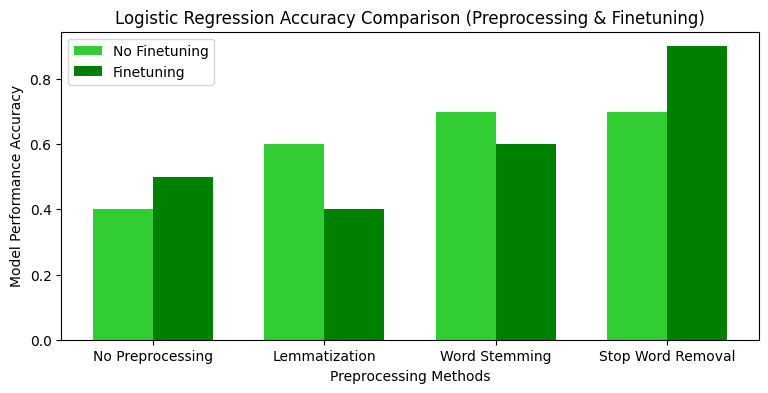

In [28]:
Categories = ['No Preprocessing', 'Lemmatization', 'Word Stemming', 'Stop Word Removal']
no_finetune = [lr_accuracy, lr_lemma_accuracy, lr_stem_accuracy, lr_stopword_accuracy]
finetuning = [best_lr_accuracy, best_lr_lemma_accuracy, best_lr_stem_accuracy, best_lr_stopword_accuracy]

bar_width = 0.35
index = np.arange(len(Categories))

plt.figure(figsize=(9, 4))
plt.bar(index, no_finetune, bar_width, label='No Finetuning', color='limegreen')
plt.bar(index + bar_width, finetuning, bar_width, label='Finetuning', color='g')

plt.xlabel('Preprocessing Methods')
plt.ylabel('Model Performance Accuracy')
plt.title('Logistic Regression Accuracy Comparison (Preprocessing & Finetuning)')
plt.xticks(index + bar_width / 2, Categories)
plt.legend()
plt.show()

#Model Selection

---


Once all models and their respective manipulations have been performed and evaluated, now it is time to select and implement the final model that will be used for the chrome extension.

In [29]:
vect_final = TfidfVectorizer()
x_stopword_test=vect_final.transform(x_stopword_test)

# Vectorize the content sets
x_train=vect_final.fit_transform(x_stopword_train)
x_test=vect_final.transform(x_stopword_test)

In [31]:
# Save the final content and model
pickle.dump(vect_final, open('vector.pkl', 'wb'))
pickle.dump(finetune_stopword_best, open('model.pkl', 'wb'))

# Load the saved model
vector_model = pickle.load(open('vector.pkl', 'rb'))
model = pickle.load(open('model.pkl', 'rb'))

In [32]:
def EDTrigger(content):
  # preprocessing of choice
  content = removeStopWord(content)

  # convert text to vector
  input = [content]
  vector = vector.transform(input)

  # predict using final model
  prediction = model.predict(vector)
  return prediction